In [15]:
import json
import scanpy as sc
import numpy as np
import torch
from umap import UMAP
import matplotlib.pyplot as plt

In [2]:
# load tokens from heart dataset
path = '../data/heart_1Mio_1500_vocab.json'
with open(path, 'r') as f:
    heart_token = json.load(f)
heart_token

{'<pad>': 0,
 'ABCA1': 1,
 'ABCB1': 2,
 'ABCC9': 3,
 'RP1-127H14.3': 4,
 'AC003991.3': 5,
 'RP5-837J1.3': 6,
 'RP1-130H16.18': 7,
 'RP11-523H20.3': 8,
 'RP11-269G24.4': 9,
 'RP11-121A8.1': 10,
 'RP5-940J5.9': 11,
 'RP1-56K13.3': 12,
 'AC007319.1': 13,
 'RP11-242P2.1': 14,
 'RP11-242P2.2': 15,
 'RP11-729I10.2': 16,
 'CTD-2616J11.11': 17,
 'RP11-77K12.7': 18,
 'AC009227.2': 19,
 'AC009495.3': 20,
 'RP11-82L7.4': 21,
 'CTD-3193O13.13': 22,
 'AC010761.10': 23,
 'RP11-665J16.1': 24,
 'CTD-2369P2.4': 25,
 'RP11-758M4.4': 26,
 'AC012613.2': 27,
 'THBS4-AS1': 28,
 'RP11-138C9.1': 29,
 'AC092684.1': 30,
 'AC013463.2': 31,
 'RP11-1143G9.4': 32,
 'CTD-2545M3.8': 33,
 'KLRK1-AS1': 34,
 'RP11-386G21.1': 35,
 'RP11-380O24.1': 36,
 'RP11-809H16.5': 37,
 'GOLGA8M_ENSG00000261480': 38,
 'RP11-653B10.1': 39,
 'CTD-3187F8.2': 40,
 'RP11-384F7.1': 41,
 'SDK1-AS1': 42,
 'RP11-686F15.2': 43,
 'RP11-457K10.1': 44,
 'RP11-290O12.2': 45,
 'PP12613': 46,
 'AC005394.1': 47,
 'RP11-815J21.3': 48,
 'CTD-2116N17.1'

In [106]:
len(heart_token)

1629

In [18]:
pretrain_token = list(heart_token.keys())
pretrain_token

['ABCA1',
 'ABCB1',
 'ABCC9',
 'RP1-127H14.3',
 'AC003991.3',
 'RP5-837J1.3',
 'RP1-130H16.18',
 'RP11-523H20.3',
 'RP11-269G24.4',
 'RP11-121A8.1',
 'RP5-940J5.9',
 'RP1-56K13.3',
 'AC007319.1',
 'RP11-242P2.1',
 'RP11-242P2.2',
 'RP11-729I10.2',
 'CTD-2616J11.11',
 'RP11-77K12.7',
 'AC009227.2',
 'AC009495.3',
 'RP11-82L7.4',
 'CTD-3193O13.13',
 'AC010761.10',
 'RP11-665J16.1',
 'CTD-2369P2.4',
 'RP11-758M4.4',
 'AC012613.2',
 'THBS4-AS1',
 'RP11-138C9.1',
 'AC092684.1',
 'AC013463.2',
 'RP11-1143G9.4',
 'CTD-2545M3.8',
 'KLRK1-AS1',
 'RP11-386G21.1',
 'RP11-380O24.1',
 'RP11-809H16.5',
 'GOLGA8M_ENSG00000261480',
 'RP11-653B10.1',
 'CTD-3187F8.2',
 'RP11-384F7.1',
 'SDK1-AS1',
 'RP11-686F15.2',
 'RP11-457K10.1',
 'RP11-290O12.2',
 'PP12613',
 'AC005394.1',
 'RP11-815J21.3',
 'CTD-2116N17.1',
 'RP11-96O20.2',
 'CTC-498M16.4',
 'CTD-2374C24.1',
 'RP11-669M16.1',
 'AC079807.4',
 'RP11-384F7.2',
 'RP11-561P12.5',
 'RP11-368I23.4',
 'RP11-86H7.6',
 'RP11-138I1.4',
 'C1QTNF7-AS1',
 'RP11-

Load and preprocess fine tune dataset

In [10]:
# load dataset
path_finetune = '../data/heart_endothelial_cell_of_artery.h5ad'
anndata = sc.read_h5ad(path_finetune)

In [4]:
tokens = anndata.var.feature_name.values
select = [tokens[1], tokens[5], tokens[109]]
select

['A1BG-AS1', 'A2ML1', 'ABI1']

In [5]:
anndata.var.index = anndata.var.feature_name


In [6]:
anndata[:, select].X.toarray()

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)

In [11]:
# filter by counts of genes
min_counts_genes = 10
sc.pp.filter_genes(anndata, 
                   min_counts=min_counts_genes
)

# normalize counts
sc.pp.normalize_total(anndata)

# log1p transformation
# without log1p row sums are all equal, with log1p they slightly differ
sc.pp.log1p(anndata)
# get hvgs
sc.pp.highly_variable_genes(anndata, n_top_genes=200, subset=True)

In [14]:
X = anndata.X.toarray()

In [19]:
np.mean(np.count_nonzero(X, axis=1))

20.794741186180875

### Test padding

In [3]:
from preprocessor import Preprocessor
from GeneVocab import GeneVocab

In [4]:
# load dataset
path_finetune = '../data/heart_endothelial_cell_of_artery.h5ad'
anndata = sc.read_h5ad(path_finetune)

In [5]:
vocab = GeneVocab()
vocab.load_from_file('../data/heart_1Mio_1500_vocab.json')

In [6]:
p = Preprocessor(anndata, 100, n_hvg=200, vocab=None)
p.preprocess()

In [6]:
p.binned_data.shape
#p._pad(vocab_size=len(vocab.vocab)-1)

In [8]:
p.binned_data.shape

(42405, 200)

In [18]:
def plot_UMAP(src_expression_profiles):
    umap_2d = UMAP(n_components=2, init='random', random_state=0)
    src_expression_profiles = np.round(src_expression_profiles, decimals=5)
    proj_2d = umap_2d.fit_transform(src_expression_profiles)
    fig = plt.figure(figsize=(10, 7))
    # sample vs generated
    plt.scatter(proj_2d[:, 0], proj_2d[:, 1], c='blue', alpha=.5, label='data', s=10)
    plt.legend()

    plt.show()

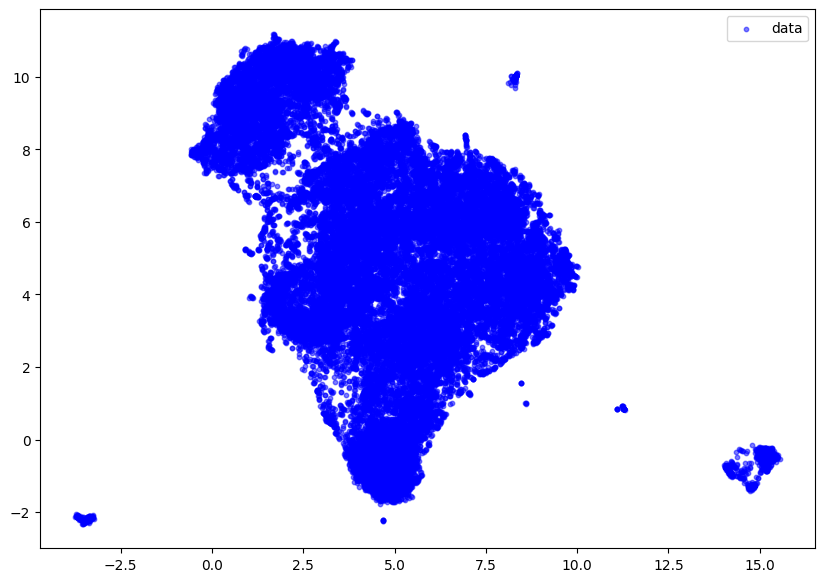

In [19]:
plot_UMAP(p.binned_data)

In [20]:
path='../data/spleen_generated_samples_mean_profile.npy'
spleen = np.load(path)

In [21]:
spleen.shape

(10001, 500)

In [23]:
def plot_UMAP(generted_expression_profiles, src_expression_profiles):
    umap_2d = UMAP(n_components=2, init='random', random_state=0)
    proj_2d = umap_2d.fit_transform(np.vstack([src_expression_profiles, generted_expression_profiles]))
    n_src = src_expression_profiles.shape[0]
    print(f'n_src: {n_src}')
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    # sample vs generated
    ax[0].scatter(proj_2d[:n_src, 0], proj_2d[:n_src, 1], c='blue', alpha=.5, label='data', s=10)
    ax[0].scatter(proj_2d[n_src:, 0], proj_2d[n_src:, 1], c='yellow', alpha=.5, label='generated', s=10)
    ax[0].legend()
    fig.suptitle(f'umap of binned expression profiles')
    fig.supxlabel('umap 1')
    fig.supylabel('umap 2')
    ax[1].scatter(proj_2d[:n_src, 0], proj_2d[:n_src, 1], alpha=.5, s=10)

    plt.show()

In [24]:
plot_UMAP(spleen, original)

NameError: name 'original' is not defined

A cell in the fine tune dataset has on average 20 non zero genes.

In [22]:
token_finetune = anndata.var.feature_name.values

## Intersection of pre train and fine tune dataset

In [23]:
pretrain_set = set(heart_token)
finetune_set = set(token_finetune)

intersect = pretrain_set.intersection(finetune_set)
print(len(intersect))

72


In [88]:
len(heart_token)

1500

In [89]:
len(pretrain_set.union(finetune_set))

1629

In [90]:
len(finetune_set.difference(pretrain_set))

128

## United vocabulary

The aim of the united vocabulary is to include all hvgs in the fine tune dataset also in the pretrain dataset

In [12]:
class GeneVocab:
    """
    Vocabulary for genes
    """
    def __int__(self):
        self.vocab: dict
        self.pad_token: str = "<pad>"

    def init(self):
        """
        create dict with only a pad token
        """
        self.vocab = {}
        self.vocab["<pad>"] = 0
        print(self.vocab)

    def extend(self, tokens):
        """
        includes new tokens in the dict
        """
        next_id = self.get_last_id() + 1
        idx = next_id
        print(idx)
        for token in tokens:
            if token not in self.vocab:
                self.vocab[token] = idx
                idx += 1
                
    def get_tokens(self):
        return list(self.vocab.values())
    
    def get_last_id(self) -> int:
        ids = list(sorted(self.vocab.values()))
        return ids[-1]

    def save_to_file(self, path_vocab) -> None:
        with open(path_vocab, 'w') as f:
            # write the dictionary to the file in JSON format
            json.dump(self.vocab, f)
            
    def load_from_file(self, path_file):
        """
        load an existing, at least initialized vocabulary from a json file
        """
        with open(path_file, 'r') as f:
            self.vocab = json.load(f)

In [13]:
vocab = GeneVocab()

In [14]:
vocab.init()
vocab.extend(list(heart_token.keys()))
len(vocab.vocab)

{'<pad>': 0}
1


1629

In [16]:
torch.tensor(vocab.get_tokens()[1:])

tensor([   1,    2,    3,  ..., 1626, 1627, 1628])

In [103]:
vocab = GeneVocab()
vocab.load_from_file('../data/heart_1Mio_1500_vocab.json')

In [104]:
vocab.vocab

{'ABCA1': 1,
 'ABCB1': 2,
 'ABCC9': 3,
 'RP1-127H14.3': 4,
 'AC003991.3': 5,
 'RP5-837J1.3': 6,
 'RP1-130H16.18': 7,
 'RP11-523H20.3': 8,
 'RP11-269G24.4': 9,
 'RP11-121A8.1': 10,
 'RP5-940J5.9': 11,
 'RP1-56K13.3': 12,
 'AC007319.1': 13,
 'RP11-242P2.1': 14,
 'RP11-242P2.2': 15,
 'RP11-729I10.2': 16,
 'CTD-2616J11.11': 17,
 'RP11-77K12.7': 18,
 'AC009227.2': 19,
 'AC009495.3': 20,
 'RP11-82L7.4': 21,
 'CTD-3193O13.13': 22,
 'AC010761.10': 23,
 'RP11-665J16.1': 24,
 'CTD-2369P2.4': 25,
 'RP11-758M4.4': 26,
 'AC012613.2': 27,
 'THBS4-AS1': 28,
 'RP11-138C9.1': 29,
 'AC092684.1': 30,
 'AC013463.2': 31,
 'RP11-1143G9.4': 32,
 'CTD-2545M3.8': 33,
 'KLRK1-AS1': 34,
 'RP11-386G21.1': 35,
 'RP11-380O24.1': 36,
 'RP11-809H16.5': 37,
 'GOLGA8M_ENSG00000261480': 38,
 'RP11-653B10.1': 39,
 'CTD-3187F8.2': 40,
 'RP11-384F7.1': 41,
 'SDK1-AS1': 42,
 'RP11-686F15.2': 43,
 'RP11-457K10.1': 44,
 'RP11-290O12.2': 45,
 'PP12613': 46,
 'AC005394.1': 47,
 'RP11-815J21.3': 48,
 'CTD-2116N17.1': 49,
 'RP11-